<a href="https://colab.research.google.com/github/ammarvellous/Autograd/blob/main/Micrograd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def f(x):
  return 3*x**2 - 4*x +5

In [ ]:
f(3.0)

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
h = 0.000000001
x = 2/3
(f(x+h)-f(x))/h

In [ ]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

In [ ]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
c+=h
d2 = a*b+c

print(d1)
print(d2)
print((d2-d1)/h)

In [2]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data}, grad={self.grad})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out =  Value(self.data+other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0*out.grad
      other.grad += 1.0*out.grad

    out._backward = _backward
    return out

  def __neg__(self):
    return self*-1

  def __sub__(self, other):
    return self + (-1*other)

  def __radd__(self, other):
    return self+other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data*other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float))
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other-1)) * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self*other

  def __truediv__(self, other):
    return self * other**-1

  def tanh(self):
    n = self.data
    t = ((math.exp(2*n) - 1)/(math.exp(2*n)+1))
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1-t**2)* out.grad

    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # Changed from = to +=
    out._backward = _backward

    return out

  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
        node._backward()

In [ ]:
a = Value(2.0)
b = Value(4.0)
-b

In [ ]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
l = d+f; l.label = 'l'

d

In [3]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
    for child in v._prev:
      edges.add((child, v))
      build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'TB'}) # Changed rankdir to 'TB' for top-to-bottom layout

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this op node to the value node
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
draw_dot(l)

In [ ]:
l.backward()

In [ ]:
l.grad = 1
d.grad = f.data
f.grad = d.data
c.grad = d.grad*1
e.grad = d.grad*1
a.grad = e.grad*b.data
b.grad = e.grad*a.data

In [110]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'output'

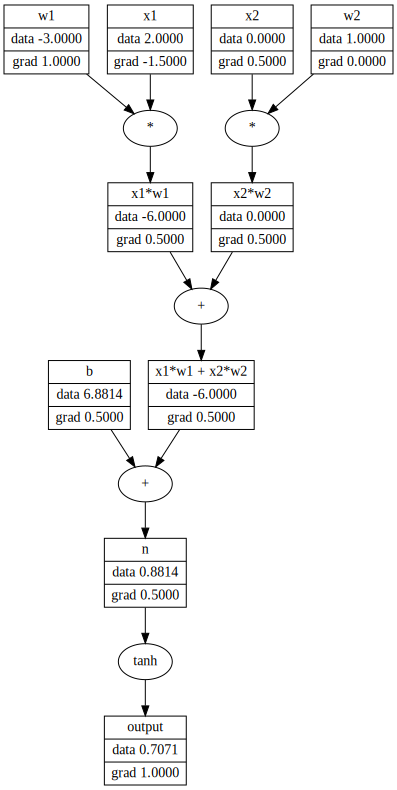

In [113]:
draw_dot(o)

In [112]:
o.backward()

In [ ]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label='x1*w1'
x2w2 = x2*w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# _________
e = (2*n).exp()
o = (e-1)/(e+1); o.label = 'output'
# ___________
o.backward()
draw_dot(o)

In [115]:
import torch

In [116]:

x1 = torch.Tensor([2.0]).double()           ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()           ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()          ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()           ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True

n = x1*w1+x2*w2 + b
o = torch.tanh(n)
o.backward()

print(o.item())

print("_______")
print('x1', x1.grad.item())
print('w1', w1.grad.item())
print('x1', x2.grad.item())
print('w1', w2.grad.item())

0.7071066904050358
_______
x1 -1.5000003851533106
w1 1.0000002567688737
x1 0.5000001283844369
w1 0.0


In [8]:
import random

In [4]:
class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w*x + b
    act = sum((xi*wi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layers in self.layers:
      x = layers(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [120]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
y = n(x)

In [121]:
y.backward()

In [118]:
len(n.parameters())

41

In [ ]:
draw_dot(n(x))

In [97]:
xs = [[2.0, 3.0, -1.0],
      [3.0,  -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]

In [108]:
EPOCH = 50
LR = 0.05
for k in range(EPOCH):
  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  #backward pass
  # clear out the existing grads, as they are no longer needed for next backward pass
  # we are only dealing with data here,
  for p in n.parameters():
    p.grad =  0.0
  loss.backward()

  #update(grad desc)
  # and now as the grads get accumulated, we dont want them to add it to previous obsolete grads
  # instead these are fresh sets of grads so it shoudl be added to 0s
  for p in n.parameters():
    p.data += -LR * p.grad

  print(k, loss.data)


0 0.005721869163875541
1 0.005690993401144348
2 0.005660430995614073
3 0.0056301773112149445
4 0.005600227801669461
5 0.005570578008348226
6 0.005541223558186361
7 0.005512160161658929
8 0.005483383610813119
9 0.005454889777355306
10 0.005426674610791535
11 0.005398734136619513
12 0.0053710644545702235
13 0.0053436617368981705
14 0.005316522226718081
15 0.005289642236387008
16 0.005263018145930408
17 0.0052366464015102905
18 0.005210523513935049
19 0.005184646057208671
20 0.005159010667118962
21 0.00513361403986295
22 0.005108452930708772
23 0.005083524152692678
24 0.005058824575350127
25 0.005034351123479997
26 0.00501010077594099
27 0.004986070564478911
28 0.004962257572584516
29 0.004938658934380332
30 0.0049152718335358885
31 0.0048920935022110194
32 0.004869121220025287
33 0.004846352313053848
34 0.004823784152848483
35 0.0048014141554828605
36 0.004779239780622084
37 0.004757258530614779
38 0.004735467949608139
39 0.0047138656226844745
40 0.004692449175018965
41 0.004671216271058

In [109]:
ypred

[Value(data=0.9789595083592437, grad=-0.04208098328151255),
 Value(data=-0.9697375742960158, grad=0.06052485140796837),
 Value(data=-0.9584149112077817, grad=0.08317017758443668),
 Value(data=0.9623190183160324, grad=-0.07536196336793521)]